In [1]:
import torch
from torchsummary import summary
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Data Loading and Preprocessing

In [3]:
PATH_TO_NPZ = "./drive/MyDrive/CS512_Project/data/dump/Data_All_Pix_Extreme.npz"
loaded_data = np.load(PATH_TO_NPZ)
print(loaded_data.files)

['train_x', 'train_y', 'val_x', 'val_y', 'test_x', 'test_y']


In [4]:
train_x = loaded_data['train_x'].astype('float32')
train_y = loaded_data['train_y'].astype('float32')
val_x = loaded_data['val_x'].astype('float32')
val_y = loaded_data['val_y'].astype('float32')
test_x = loaded_data['test_x'].astype('float32')
test_y = loaded_data['test_y'].astype('float32')

print("Training set :", train_x.shape, train_y.shape)
print("Validation set :", val_x.shape, val_y.shape)
print("Test set :", test_x.shape, test_y.shape)

Training set : (10718, 112, 112, 3) (10718, 112, 112, 3)
Validation set : (1191, 112, 112, 3) (1191, 112, 112, 3)
Test set : (1324, 112, 112, 3) (1324, 112, 112, 3)


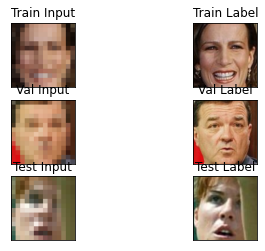

In [5]:
plt.subplot(321), plt.imshow(train_x[0].astype('int')), plt.title("Train Input"), plt.xticks([]), plt.yticks([])
plt.subplot(322), plt.imshow(train_y[0].astype('int')), plt.title("Train Label"), plt.xticks([]), plt.yticks([])
plt.subplot(323), plt.imshow(val_x[0].astype('int')), plt.title("Val Input"), plt.xticks([]), plt.yticks([])
plt.subplot(324), plt.imshow(val_y[0].astype('int')), plt.title("Val Label"), plt.xticks([]), plt.yticks([])
plt.subplot(325), plt.imshow(test_x[0].astype('int')), plt.title("Test Input"), plt.xticks([]), plt.yticks([])
plt.subplot(326), plt.imshow(test_y[0].astype('int')), plt.title("Test Label"), plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
del loaded_data

In [7]:
# Normalizing Images
for i in range(len(train_x)):
    train_x[i] = (train_x[i] - np.mean(train_x[i]))/255.0
    train_y[i] = (train_y[i] - np.mean(train_y[i]))/255.0

for i in range(len(val_x)):
    val_x[i] = (val_x[i] - np.mean(val_x[i]))/255.0
    val_y[i] = (val_y[i] - np.mean(val_y[i]))/255.0

for i in range(len(test_x)):
    test_x[i] = (test_x[i] - np.mean(test_x[i]))/255.0
    test_y[i] = (test_y[i] - np.mean(test_y[i]))/255.0

In [8]:
np.min(train_x), np.max(train_x) , np.min(train_y), np.max(train_y)

(-0.73754174, 0.7140656, -0.78723085, 0.7925307)

In [9]:
# Converting images from HxWxC format to CxHxW format
train_x = np.moveaxis(train_x, -1, 1)
train_y = np.moveaxis(train_y, -1, 1)
val_x = np.moveaxis(val_x, -1, 1)
val_y = np.moveaxis(val_y, -1, 1)
test_x = np.moveaxis(test_x, -1, 1)
test_y = np.moveaxis(test_y, -1, 1)
print("Training set :", train_x.shape, train_y.shape)
print("Validation set :", val_x.shape, val_y.shape)
print("Test set :", test_x.shape, test_y.shape)

Training set : (10718, 3, 112, 112) (10718, 3, 112, 112)
Validation set : (1191, 3, 112, 112) (1191, 3, 112, 112)
Test set : (1324, 3, 112, 112) (1324, 3, 112, 112)


In [10]:
import gc
gc.collect()

9554

In [11]:
train_x = torch.tensor(train_x, dtype=torch.float)
train_y = torch.tensor(train_y, dtype=torch.float)

val_x = torch.tensor(val_x, dtype=torch.float)
val_y = torch.tensor(val_y, dtype=torch.float)

test_x = torch.tensor(test_x, dtype=torch.float)
test_y = torch.tensor(test_y, dtype=torch.float)

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 4

train_data = TensorDataset(train_x, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_x, val_y)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_x, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Utility Functions

In [13]:
def display_something(input, output, label):
    i = np.array((np.moveaxis(input.cpu().numpy(),0,-1) + 1) *127.5, dtype=np.int)
    o = np.array((np.moveaxis(output.data.cpu().numpy(),0,-1) + 1) *127.5, dtype=np.int)
    l = np.array((np.moveaxis(label.cpu().numpy(),0,-1) + 1) *127.5, dtype=np.int)
    plt.subplot(131), plt.imshow(i), plt.title("Input"), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(o), plt.title("Output"), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(l), plt.title("Label"), plt.xticks([]), plt.yticks([])
    plt.show()

In [14]:
import matplotlib.pyplot as plt
def show_progression(logs, latest_epochs=10):
    # fig, ax = plt.subplots(latest_epochs, 3, figsize=(30,30)) 
    for i in range(latest_epochs):
        i_ = np.array((np.moveaxis(logs[3*i],0,-1) + 1) *127.5, dtype=np.int)
        o = np.array((np.moveaxis(logs[3*i+1],0,-1) + 1) *127.5, dtype=np.int)
        l = np.array((np.moveaxis(logs[3*i+2],0,-1) + 1) *127.5, dtype=np.int)

        print(f"Epoch {i}")
        plt.subplot(131), plt.imshow(i_), plt.title("Input"), plt.xticks([]), plt.yticks([])
        plt.subplot(132), plt.imshow(o), plt.title("Output"), plt.xticks([]), plt.yticks([])
        plt.subplot(133), plt.imshow(l), plt.title("Label"), plt.xticks([]), plt.yticks([])
        plt.show()

# Model Construction

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Conv2d, BatchNorm2d, ReLU, Tanh, ConvTranspose2d, Sigmoid

In [16]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels,):
        super(Residual, self).__init__()

        self.conv_1 = Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.conv_2 = Conv2d(256, out_channels, kernel_size=3, padding=1)
        self.conv_1x1 = None

        self.bn_1 = BatchNorm2d(256)
        self.bn_2 = BatchNorm2d(out_channels)

        self.relu = ReLU(inplace=True)

        if in_channels != out_channels:
            self.conv_1x1 = Conv2d(in_channels, out_channels, kernel_size=1)


    def forward(self, x):
        x_ = self.relu(self.bn_1(self.conv_1(x)))
        x_ = self.bn_2(self.conv_2(x_))
        x2_ = x
        if self.conv_1x1:
            x2_ = self.conv_1x1(x)
        
        y = x_ + x2_
        return self.relu(y)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.first_conv_layers = Sequential(
            Conv2d(3, 64,  kernel_size=9, stride=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            Conv2d(64, 64, kernel_size=4, stride=2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            Conv2d(64, 128, kernel_size=4, stride=2),
            BatchNorm2d(128),
            ReLU(inplace=True),
            Conv2d(128, 256, kernel_size=4, stride=2),
            BatchNorm2d(256),
            ReLU(inplace=True)
        )

        self.second_residual_blocks = Sequential(
            Residual(256, 256),
            Residual(256, 256),
            Residual(256, 256)
        )

        self.third_t_conv = Sequential(
            ConvTranspose2d(256,256, kernel_size=4, stride=2),
            BatchNorm2d(256),
            ReLU(inplace=True),
            ConvTranspose2d(256,128, kernel_size=4, stride=2),
            BatchNorm2d(128),
            ReLU(inplace=True),
            ConvTranspose2d(128,64, kernel_size=4, stride=2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            ConvTranspose2d(64,3, kernel_size=11),# Comeback to this.
            Tanh()
            # ReLU(inplace=True)
            # Sigmoid()
        )

    def forward(self, x):
        x_ = self.first_conv_layers(x)
        x_ = self.second_residual_blocks(x_)
        x_ = self.third_t_conv(x_)
        # print(f"Shape of x_ = {x_.size()}")
        return x_


net = Net()

In [18]:
net.to(device)
summary(net, (3, 112, 112), batch_size=8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 104, 104]          15,616
       BatchNorm2d-2          [8, 64, 104, 104]             128
              ReLU-3          [8, 64, 104, 104]               0
            Conv2d-4            [8, 64, 51, 51]          65,600
       BatchNorm2d-5            [8, 64, 51, 51]             128
              ReLU-6            [8, 64, 51, 51]               0
            Conv2d-7           [8, 128, 24, 24]         131,200
       BatchNorm2d-8           [8, 128, 24, 24]             256
              ReLU-9           [8, 128, 24, 24]               0
           Conv2d-10           [8, 256, 11, 11]         524,544
      BatchNorm2d-11           [8, 256, 11, 11]             512
             ReLU-12           [8, 256, 11, 11]               0
           Conv2d-13           [8, 256, 11, 11]         590,080
      BatchNorm2d-14           [8, 256,

In [19]:
from torch.nn import MSELoss
from skimage.metrics import structural_similarity
def pixel_loss(y_true, y_pred):
    return torch.square(torch.norm(y_pred - y_true)) / (112*112*3)

In [20]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

# Training Phase

In [21]:
train_log = []
validation_log = []
loss_per_epoch = []
val_loss_per_epoch = []
val_acc_per_epoch = []

In [22]:
def train(epoch, fresh_run=False):
    global train_log, validation_log, loss_per_epoch, val_loss_per_epoch, val_acc_per_epoch
    if fresh_run:
        train_log = []
        validation_log = []
        loss_per_epoch = []
        val_loss_per_epoch = []
        val_acc_per_epoch = []
    for i in range(epoch):
        net.train()
        total_loss=0
        print("")
        print(f"Training @ epoch {i}")
        for step, batch in enumerate(train_dataloader):

            b_inputs = batch[0].to(device)
            b_labels = batch[1].to(device)

            net.zero_grad()

            forward_output = net(b_inputs)

            if step == 10:
                display_something(b_inputs[0], forward_output[0], b_labels[0])
                train_log.append(b_inputs[0].cpu().numpy())
                train_log.append(forward_output[0].data.cpu().numpy())
                train_log.append(b_labels[0].cpu().numpy())

            # print(forward_output[0].shape)
            # print("OP","-"*20)
            # print(forward_output[0])
            # print("IP","-"*20)
            # print(b_inputs[0])
            # print("GT","-"*20)
            # print(b_labels[0])
            

            loss = pixel_loss(b_labels, forward_output)
            total_loss += loss.item()
            # print(loss.item())
            loss.backward()

            # if net.third_t_conv[0].weight.grad != None:
            #     print("Loss", "-"*20, total_loss)
            #     print(" | After back :", net.third_t_conv[0].weight.grad, " Loss =", loss)
            optimizer.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader) 
        loss_per_epoch.append(total_loss)           

        print("Total training loss: {0:.8f}".format(total_loss))



        print("")
        print(f"Running Validation for epoch {i}")
        net.eval()
        eval_accuracy, nb_eval_steps, nb_eval_examples = 0.0, 0, 0
        total_val_loss = 0.0
        once = False
        for batch in validation_dataloader:
            
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            
            # Unpack the inputs from our dataloader
            b_inputs, b_labels = batch
            
            with torch.no_grad():        
                outputs = net(b_inputs)

            val_loss = pixel_loss(b_labels, outputs)
            total_val_loss += val_loss.item()
            if not once:
                display_something(b_inputs[0], outputs[0], b_labels[0])
                once = True
            
            outputs = outputs.detach().cpu().numpy()
            labels = b_labels.cpu().numpy()

            temp_eval_accuracy = 0.0
            for y1, y2 in zip(outputs, labels):
                mssim = structural_similarity(np.moveaxis(y1,0,-1).astype(np.float32), np.moveaxis(y2,0,-1).astype(np.float32), multichannel=True)
                temp_eval_accuracy += mssim
            
            # Accumulate the total accuracy.
            eval_accuracy += (temp_eval_accuracy/len(outputs))
            # Track the number of batches
            nb_eval_steps += 1
        print(f"Validation Accuracy @ epoch {i} : {eval_accuracy/nb_eval_steps}")
        print(f"Total Validation Loss @ epoch {i} : {total_val_loss}")
        val_loss_per_epoch.append(total_val_loss)
        val_acc_per_epoch.append(eval_accuracy/nb_eval_steps)
        print("-"*20,"EPOCH COMPLETE", "-"*20)


Training @ epoch 0


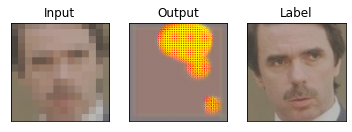

Total training loss: 220.83539368

Running Validation for epoch 0


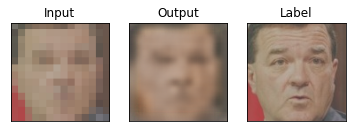

Validation Accuracy @ epoch 0 : 0.645045158335464
Total Validation Loss @ epoch 0 : 7.995876361615956
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 1


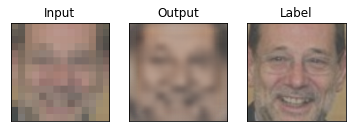

Total training loss: 69.08600217

Running Validation for epoch 1


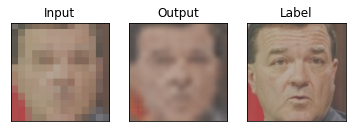

Validation Accuracy @ epoch 1 : 0.6767934788493988
Total Validation Loss @ epoch 1 : 6.597687190398574
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 2


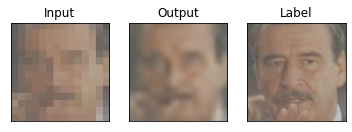

Total training loss: 59.38735801

Running Validation for epoch 2


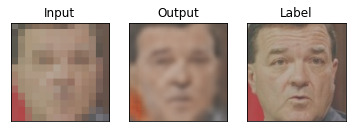

Validation Accuracy @ epoch 2 : 0.703346296434654
Total Validation Loss @ epoch 2 : 5.5527800573036075
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 3


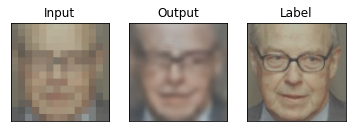

Total training loss: 53.79098269

Running Validation for epoch 3


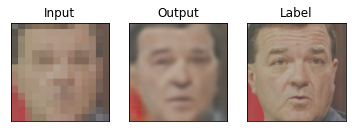

Validation Accuracy @ epoch 3 : 0.7144486524758816
Total Validation Loss @ epoch 3 : 5.430667205713689
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 4


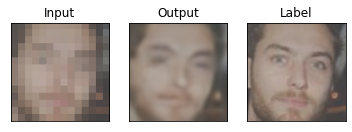

Total training loss: 51.42438654

Running Validation for epoch 4


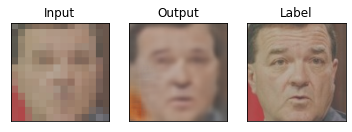

Validation Accuracy @ epoch 4 : 0.7209535610261548
Total Validation Loss @ epoch 4 : 5.1291251089423895
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 5


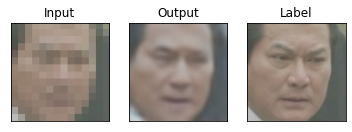

Total training loss: 47.75068353

Running Validation for epoch 5


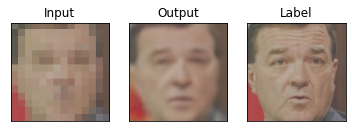

Validation Accuracy @ epoch 5 : 0.7551392143854356
Total Validation Loss @ epoch 5 : 4.444485663436353
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 6


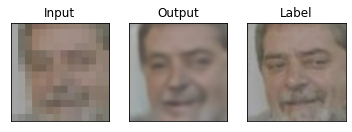

Total training loss: 43.74855032

Running Validation for epoch 6


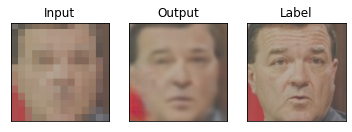

Validation Accuracy @ epoch 6 : 0.7592456648898698
Total Validation Loss @ epoch 6 : 4.383753172121942
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 7


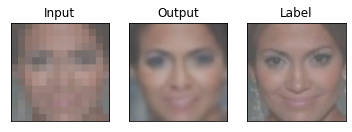

Total training loss: 41.57367314

Running Validation for epoch 7


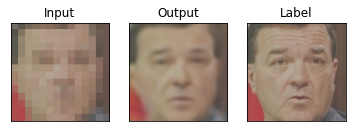

Validation Accuracy @ epoch 7 : 0.7577286933900163
Total Validation Loss @ epoch 7 : 4.198626431170851
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 8


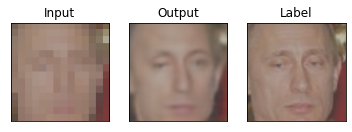

Total training loss: 39.74563522

Running Validation for epoch 8


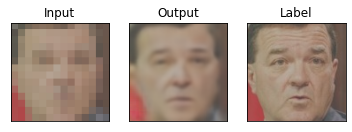

Validation Accuracy @ epoch 8 : 0.7418203952481034
Total Validation Loss @ epoch 8 : 7.391100196633488
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 9


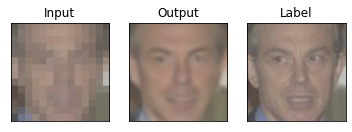

Total training loss: 39.24382435

Running Validation for epoch 9


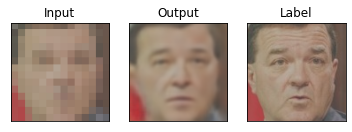

Validation Accuracy @ epoch 9 : 0.762599786905657
Total Validation Loss @ epoch 9 : 4.460767065640539
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 10


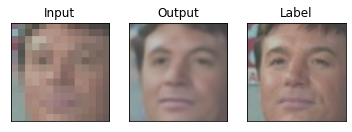

Total training loss: 37.93142386

Running Validation for epoch 10


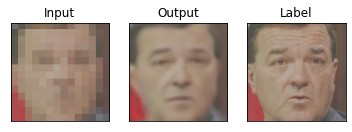

Validation Accuracy @ epoch 10 : 0.7746374656208669
Total Validation Loss @ epoch 10 : 3.9792050747200847
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 11


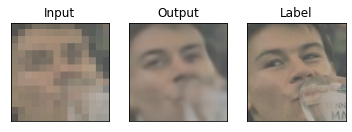

Total training loss: 37.62435864

Running Validation for epoch 11


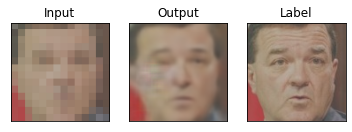

Validation Accuracy @ epoch 11 : 0.7749277386915367
Total Validation Loss @ epoch 11 : 4.018051749560982
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 12


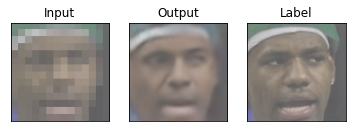

Total training loss: 35.82050020

Running Validation for epoch 12


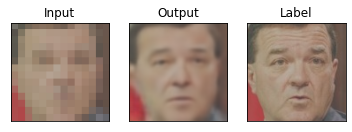

Validation Accuracy @ epoch 12 : 0.7791933165799989
Total Validation Loss @ epoch 12 : 4.347385650034994
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 13


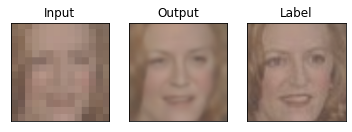

Total training loss: 34.87213246

Running Validation for epoch 13


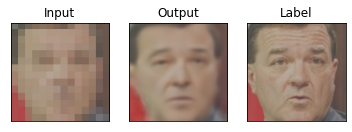

Validation Accuracy @ epoch 13 : 0.7735162430463463
Total Validation Loss @ epoch 13 : 6.083307323046029
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 14


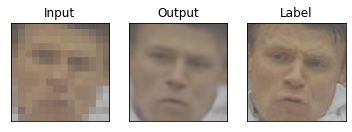

Total training loss: 34.51830489

Running Validation for epoch 14


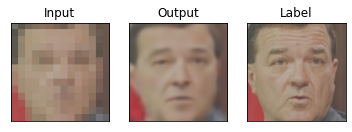

Validation Accuracy @ epoch 14 : 0.7866608202350674
Total Validation Loss @ epoch 14 : 3.930174089502543
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 15


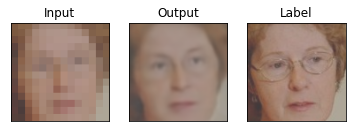

Total training loss: 47.16665541

Running Validation for epoch 15


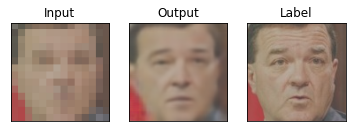

Validation Accuracy @ epoch 15 : 0.7643463676839424
Total Validation Loss @ epoch 15 : 5.411946919746697
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 16


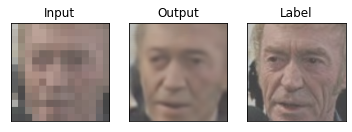

Total training loss: 34.66391149

Running Validation for epoch 16


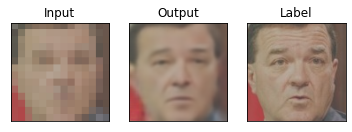

Validation Accuracy @ epoch 16 : 0.7692560458184781
Total Validation Loss @ epoch 16 : 5.3626166973263025
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 17


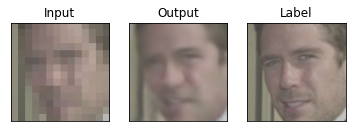

Total training loss: 32.78977079

Running Validation for epoch 17


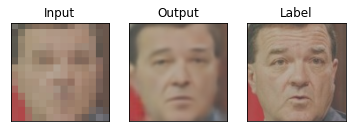

Validation Accuracy @ epoch 17 : 0.7664257126098348
Total Validation Loss @ epoch 17 : 6.129281948320568
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 18


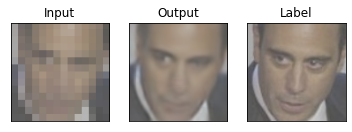

Total training loss: 32.31575803

Running Validation for epoch 18


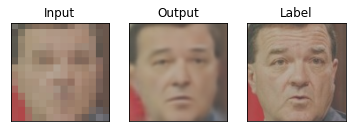

Validation Accuracy @ epoch 18 : 0.7712155386354947
Total Validation Loss @ epoch 18 : 4.831668292172253
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 19


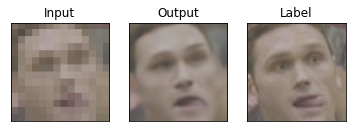

Total training loss: 40.20977427

Running Validation for epoch 19


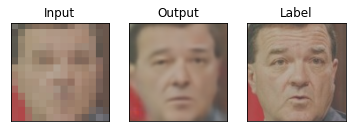

Validation Accuracy @ epoch 19 : 0.7662704829924621
Total Validation Loss @ epoch 19 : 5.428169181104749
-------------------- EPOCH COMPLETE --------------------


In [23]:
train(20, fresh_run=True)


Training @ epoch 0


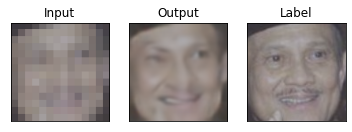

Total training loss: 30.89005619

Running Validation for epoch 0


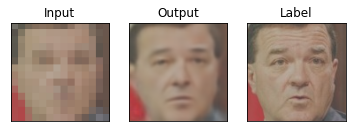

Validation Accuracy @ epoch 0 : 0.7770807241977692
Total Validation Loss @ epoch 0 : 5.909918876830488
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 1


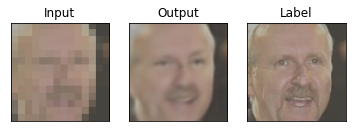

Total training loss: 29.22110508

Running Validation for epoch 1


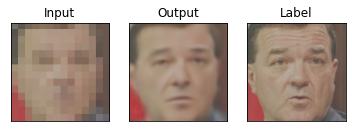

Validation Accuracy @ epoch 1 : 0.7846883830827422
Total Validation Loss @ epoch 1 : 4.978102610446513
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 2


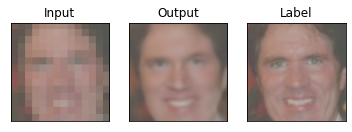

Total training loss: 28.50816989

Running Validation for epoch 2


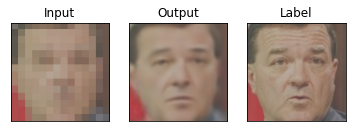

Validation Accuracy @ epoch 2 : 0.7821004134194365
Total Validation Loss @ epoch 2 : 6.246862443629652
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 3


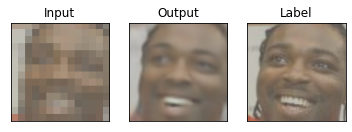

Total training loss: 28.10134537

Running Validation for epoch 3


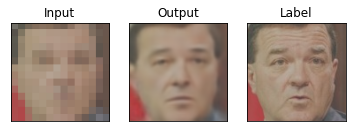

Validation Accuracy @ epoch 3 : 0.774796237112164
Total Validation Loss @ epoch 3 : 8.224056442733854
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 4


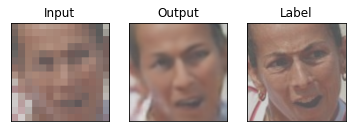

Total training loss: 27.77639759

Running Validation for epoch 4


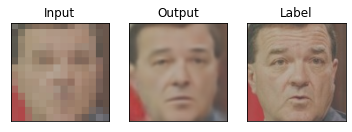

Validation Accuracy @ epoch 4 : 0.7878339849991582
Total Validation Loss @ epoch 4 : 5.2892152345739305
-------------------- EPOCH COMPLETE --------------------


In [24]:
# Reducing lr to 1e-4
optimizer = Adam(net.parameters(), lr=1e-4)
train(5)


Training @ epoch 0


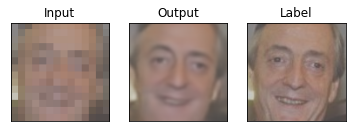

Total training loss: 27.42113311

Running Validation for epoch 0


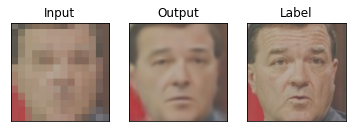

Validation Accuracy @ epoch 0 : 0.7680300295477339
Total Validation Loss @ epoch 0 : 11.240590062458068
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 1


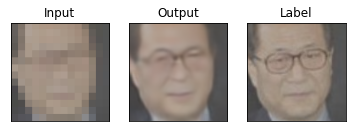

Total training loss: 27.20883751

Running Validation for epoch 1


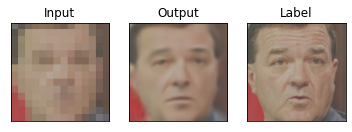

Validation Accuracy @ epoch 1 : 0.7834612439747958
Total Validation Loss @ epoch 1 : 6.852672682609409
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 2


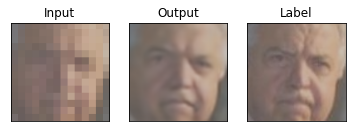

Total training loss: 26.99676952

Running Validation for epoch 2


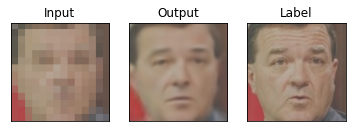

Validation Accuracy @ epoch 2 : 0.78245114243753
Total Validation Loss @ epoch 2 : 7.690275258850306
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 3


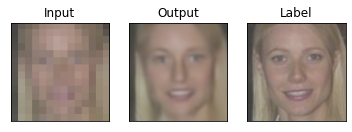

Total training loss: 26.69376989

Running Validation for epoch 3


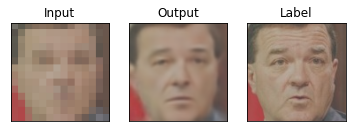

Validation Accuracy @ epoch 3 : 0.778509184096822
Total Validation Loss @ epoch 3 : 8.371092421002686
-------------------- EPOCH COMPLETE --------------------

Training @ epoch 4


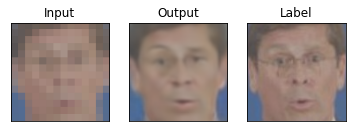

Total training loss: 26.59882233

Running Validation for epoch 4


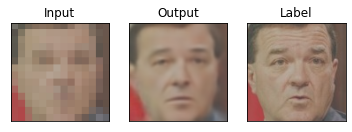

Validation Accuracy @ epoch 4 : 0.7631020368730334
Total Validation Loss @ epoch 4 : 13.529455213807523
-------------------- EPOCH COMPLETE --------------------


In [25]:
train(5) # Reduced BS to 4 from 8

# Evaluation
- Assessing the model's performance on train and validation sets

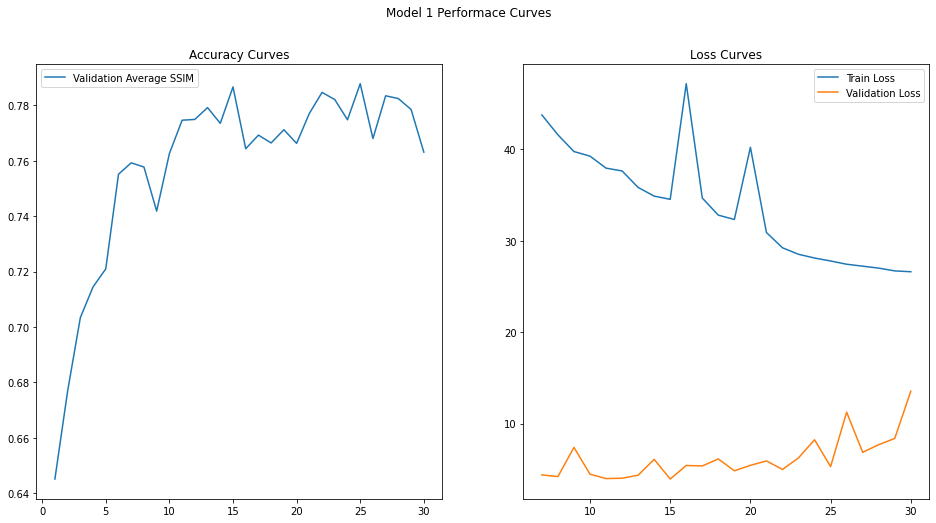

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
ax, cx = fig.subplots(1, 2)

ax.set_title("Accuracy Curves")
# ax.plot(range(1,len(fit_accuracy)+1), fit_accuracy)
ax.plot(range(1,len(val_acc_per_epoch)+1), val_acc_per_epoch)
ax.legend(['Validation Average SSIM'])

cx.set_title("Loss Curves")
cx.plot(range(7,len(loss_per_epoch)+1), loss_per_epoch[6:])
cx.plot(range(7,len(val_loss_per_epoch)+1), val_loss_per_epoch[6:])
cx.legend(['Train Loss', 'Validation Loss'])

plt.suptitle("Model 1 Performace Curves")

plt.show()

Epoch 0


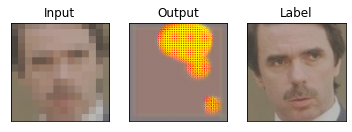

Epoch 1


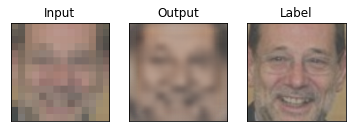

Epoch 2


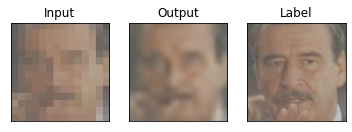

Epoch 3


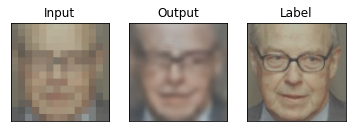

Epoch 4


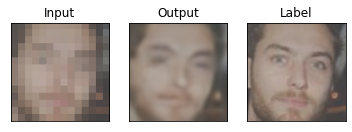

Epoch 5


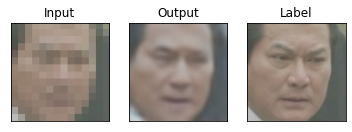

Epoch 6


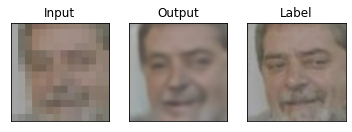

Epoch 7


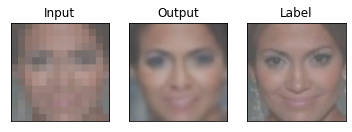

Epoch 8


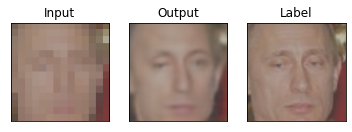

Epoch 9


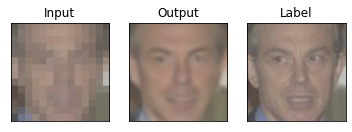

Epoch 10


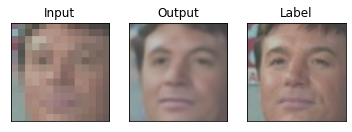

Epoch 11


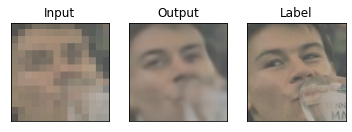

Epoch 12


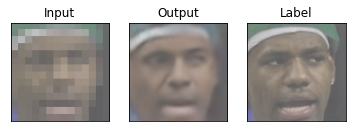

Epoch 13


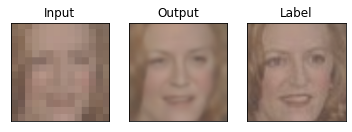

Epoch 14


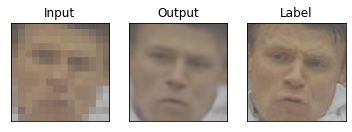

Epoch 15


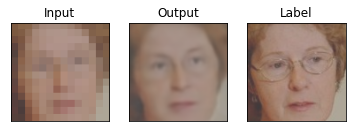

Epoch 16


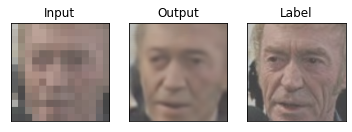

Epoch 17


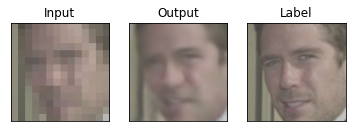

Epoch 18


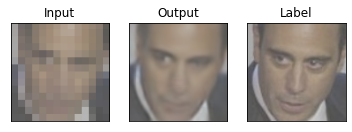

Epoch 19


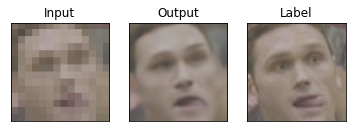

Epoch 20


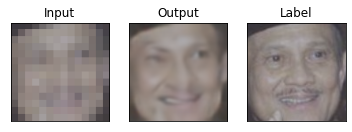

Epoch 21


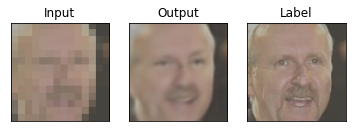

Epoch 22


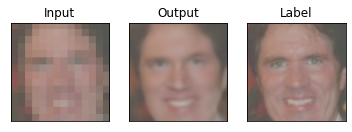

Epoch 23


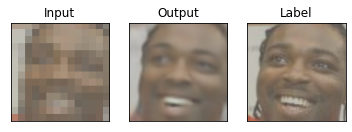

Epoch 24


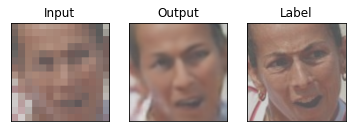

Epoch 25


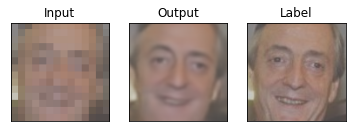

Epoch 26


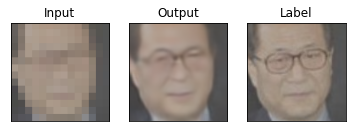

Epoch 27


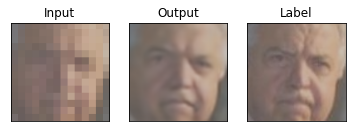

Epoch 28


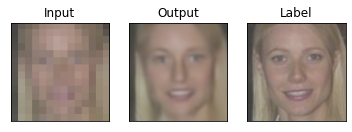

Epoch 29


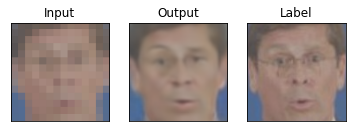

In [27]:
show_progression(train_log[:], 30)

# Testing Phase
 - Running the model on the test set

Running on Test Set


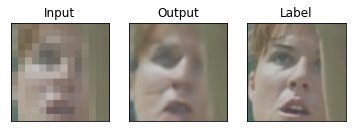

Test Accuracy : 0.756563814720378
Total Test Loss : 17.461832854896784
-------------------- TESTING COMPLETE --------------------


In [28]:
print(f"Running on Test Set")
net.eval()
eval_accuracy, nb_eval_steps, nb_eval_examples = 0.0, 0, 0
total_val_loss = 0.0
once = False
for batch in test_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_inputs, b_labels = batch
    
    with torch.no_grad():        
        outputs = net(b_inputs)

    val_loss = pixel_loss(b_labels, outputs)
    total_val_loss += val_loss.item()
    if not once:
        display_something(b_inputs[0], outputs[0], b_labels[0])
        once = True
    
    outputs = outputs.detach().cpu().numpy()
    labels = b_labels.cpu().numpy()

    temp_eval_accuracy = 0.0
    for y1, y2 in zip(outputs, labels):
        mssim = structural_similarity(np.moveaxis(y1,0,-1).astype(np.float32), np.moveaxis(y2,0,-1).astype(np.float32), multichannel=True)
        temp_eval_accuracy += mssim
    
    # Accumulate the total accuracy.
    eval_accuracy += (temp_eval_accuracy/len(outputs))
    # Track the number of batches
    nb_eval_steps += 1
print(f"Test Accuracy : {eval_accuracy/nb_eval_steps}")
print(f"Total Test Loss : {total_val_loss}")
print("-"*20,"TESTING COMPLETE", "-"*20)

# Save Results

In [29]:
torch.save(net, "./drive/MyDrive/CS512_Project/data/Final_Model_with_Results5.h5")
np.savez("./drive/MyDrive/CS512_Project/data/log_dumps5.npz",train_log=train_log, val_acc_per_epoch=val_acc_per_epoch, val_loss_per_epoch=val_loss_per_epoch, loss_per_epoch=loss_per_epoch)